In [18]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [19]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    
min_max_train_df_with_label = datasets['min_max_scale_pca']['train']
standard_train_df_with_label = datasets['standard_scale_pca']['train']

# Remove the Churn column
min_max_train_df = min_max_train_df_with_label.drop(columns=['Churn'])
standard_train_df = standard_train_df_with_label.drop(columns=['Churn'])

In [13]:
min_max_train_df.head(3)
standard_train_df.head(3)

,State_freq,State_label,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0,0.692163,0,1.247508,1.579670,0.484868,-0.058619,-0.050781,0.857403,-0.469031,-0.085020
1,0.024756,1,0.161278,0,1.320985,-0.329918,1.135375,-0.095916,0.147654,1.048458,0.149054,1.242179
2,0.018755,2,0.919686,0,-0.589414,1.179302,0.685024,-1.554439,0.494917,-0.759668,0.200561,0.704125


In [20]:
def kmeans_elbow_method(data, start, step, num_steps=10, **params):
    mse_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        mse_scores.append(model.inertia_)
    return mse_scores

def kmeans_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        silhouette_scores.append(silhouette_score(data, model.labels_, random_state=42))
    return silhouette_scores

def plot_results(results_dict, metric_name, num_steps=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, (scale_type, values) in enumerate(results_dict.items()):
        x_values = np.arange(values['start'], values['start'] + num_steps * values['step'], values['step'])
        ax[i].plot(x_values, values['results'], marker='o')
        ax[i].set_title(f'{scale_type} Scaled Data ({metric_name})')
        ax[i].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
        ax[i].set_ylabel(metric_name)
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()



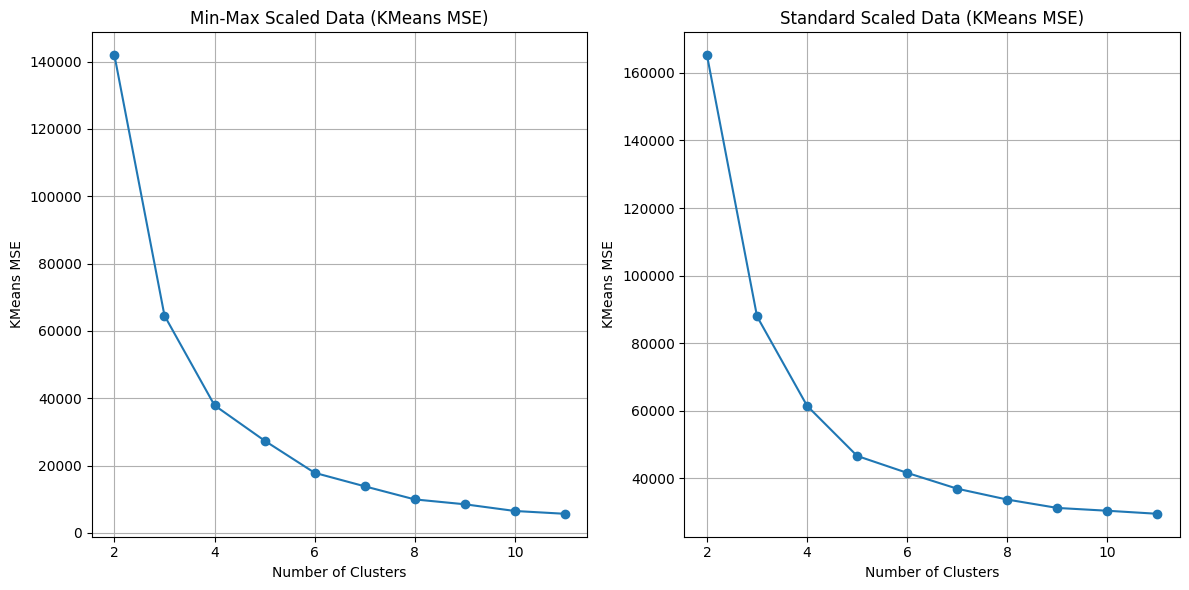

In [21]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_elbow_method(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_elbow_method(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans MSE')

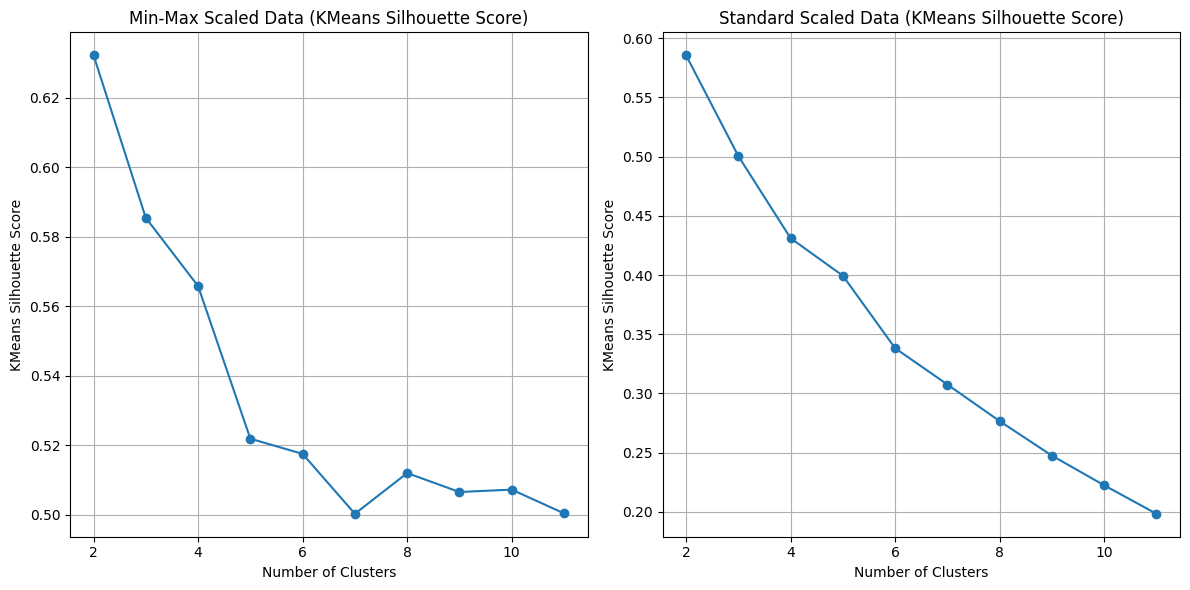

In [22]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans Silhouette Score')

​Based on the Elbow method, the plot indicates that four clusters are appropriate, as the curve forms an "elbow" at this point. Additionally, the Silhouette score analysis reveals relatively high values when the number of clusters is four or fewer. Therefore, we have selected 𝑘 = 4 as the optimal number of clusters. 
Besides, since data scaled using the min-max method yielded better Mean Squared Error (MSE) and Silhouette scores, we will proceed with this scaling technique for our analysis.​


Next we will analyze what are the similarities within a cluster.

In [ ]:
optimal_k = 4 

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
min_max_train_df['Cluster'] = kmeans.fit_predict(min_max_train_df)


In [ ]:
cluster_summary = min_max_train_df_with_label.groupby(min_max_train_df['Cluster']).mean()
print(cluster_summary)

         State_freq  State_label  Account length  International plan  \
Cluster                                                                
0          0.021971     5.416667        0.403182            0.087798   
1          0.019202    43.768992        0.407387            0.105426   
2          0.019753    17.556561        0.421107            0.101056   
3          0.020638    30.876093        0.414831            0.110787   

         Number vmail messages  Total day minutes  Total day calls  \
Cluster                                                              
0                     0.173333           0.514968         0.632403   
1                     0.159721           0.503514         0.625514   
2                     0.156591           0.509582         0.627696   
3                     0.152187           0.517991         0.622194   

         Total eve minutes  Total eve calls  Total night minutes  \
Cluster                                                            
0         

<Figure size 800x500 with 0 Axes>

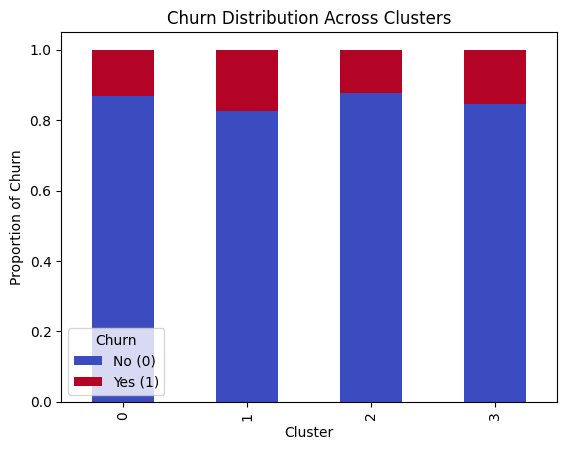

In [ ]:

min_max_train_df_with_label['Cluster'] = min_max_train_df['Cluster']
churn_distribution = min_max_train_df_with_label.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()

# Visualize the churn distribution per cluster
plt.figure(figsize=(8, 5))
churn_distribution.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.xlabel("Cluster")
plt.ylabel("Proportion of Churn")
plt.title("Churn Distribution Across Clusters")
plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
plt.show()


It can be shown from the figure that cluster 1 and 3 have higher proportion of Churn while cluster 0 and 2 have lower proportion of Churn.